# Нелинейные модели для регрессии

<p>Файл CSV включает почасовую/ежедневную сводку для Szeged, Венгрия, в период с 2006 по 2016 год.</p>

<p>Данные, доступные в почасовом ответе:</p>

- форматированная дата
- облачно/ясно/...
- осадки
- температура
- ощущение температуры
- влажность
- скорость ветра
- подшипник ветра (градусы)
- видимость (км)
- громкая обложка
- давление

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

In [2]:
filename = 'weatherHistory.csv'
df = pd.read_csv(filename, index_col='Formatted Date') 
df.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
Formatted Date,,,,,,,,,,,
2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


Некоторые данные представлены в строковом формате, но их можно проклассифицировать:

Рассмотрим данные второго столбца и соберем все отличающиеся классификации

In [3]:
summary_values = []
for i in df['Summary']:
    if not i in summary_values:
        summary_values.append(i)

In [4]:
summary_values.sort()
summary_values

['Breezy',
 'Breezy and Dry',
 'Breezy and Foggy',
 'Breezy and Mostly Cloudy',
 'Breezy and Overcast',
 'Breezy and Partly Cloudy',
 'Clear',
 'Dangerously Windy and Partly Cloudy',
 'Drizzle',
 'Dry',
 'Dry and Mostly Cloudy',
 'Dry and Partly Cloudy',
 'Foggy',
 'Humid and Mostly Cloudy',
 'Humid and Overcast',
 'Humid and Partly Cloudy',
 'Light Rain',
 'Mostly Cloudy',
 'Overcast',
 'Partly Cloudy',
 'Rain',
 'Windy',
 'Windy and Dry',
 'Windy and Foggy',
 'Windy and Mostly Cloudy',
 'Windy and Overcast',
 'Windy and Partly Cloudy']

In [5]:
s_v = {
 'Breezy': 1.0,
 'Breezy and Dry': 1.2,
 'Breezy and Foggy': 1.4,
 'Breezy and Mostly Cloudy': 1.6,
 'Breezy and Overcast': 1.8,
 'Breezy and Partly Cloudy': 2,
 'Clear': 3,
 'Dangerously Windy and Partly Cloudy': 4,
 'Drizzle': 5,
 'Dry': 6.3,
 'Dry and Mostly Cloudy': 6.6,
 'Dry and Partly Cloudy': 6.9,
 'Foggy': 8,
 'Humid and Mostly Cloudy': 9.3,
 'Humid and Overcast': 9.6,
 'Humid and Partly Cloudy': 9.9,
 'Light Rain': 11,
 'Mostly Cloudy': 12,
 'Overcast': 13,
 'Partly Cloudy': 14,
 'Rain': 15,
 'Windy': 16,
 'Windy and Dry': 16.2,
 'Windy and Foggy': 16.4,
 'Windy and Mostly Cloudy': 16.6,
 'Windy and Overcast': 16.8,
 'Windy and Partly Cloudy': 17
}

Создаем новый столбец с числовыми значениями

In [6]:
df['Summary_Nums'] = [s_v[i] for i in df['Summary']]
df.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,Summary_Nums
Formatted Date,,,,,,,,,,,,
2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,14.0
2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,14.0
2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,12.0
2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,14.0
2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,12.0


Аналогичная процедура со столбцом Осадки

In [7]:
precip_type = []
for i in df['Precip Type']:
    if not i in precip_type:
        precip_type.append(i)
precip_type

['rain', 'snow', nan]

In [8]:
p_t = {
    'rain': 1,
    'snow': 2,
    np.nan: 0
}

In [9]:
df['Precip Type_Nums'] = [p_t[i] for i in df['Precip Type']]
df.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary,Summary_Nums,Precip Type_Nums
Formatted Date,,,,,,,,,,,,,
2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.,14.0,1
2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.,14.0,1
2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.,12.0,1
2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.,14.0,1
2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.,12.0,1


Удаляем ненужные столбцы

In [10]:
final_data = df.drop(['Daily Summary', 'Summary', 'Precip Type'], axis=1)
final_data.head()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Summary_Nums,Precip Type_Nums
Formatted Date,,,,,,,,,,
2006-04-01 00:00:00.000 +0200,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,14.0,1
2006-04-01 01:00:00.000 +0200,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,14.0,1
2006-04-01 02:00:00.000 +0200,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,12.0,1
2006-04-01 03:00:00.000 +0200,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,14.0,1
2006-04-01 04:00:00.000 +0200,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,12.0,1


## kNN (k ближайших соседей)

In [11]:
from sklearn.neighbors import KNeighborsRegressor

In [12]:
X = final_data.drop(['Apparent Temperature (C)'], axis=1).values
y = final_data['Apparent Temperature (C)'].values

In [13]:
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

model = KNeighborsRegressor()

# отрицательное среднее среднеквадратичной ошибки
scoring = 'neg_mean_squared_error'
results = cross_val_score(model, X, y, cv = kfold, scoring = scoring)

print(results.mean())

-1.584336448279071


## Деревья классификации и регрессии (Decision Tree Regression)

In [14]:
from sklearn.tree import DecisionTreeRegressor

In [15]:
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

model = DecisionTreeRegressor() 

scoring = 'neg_mean_squared_error' # критерий качества
results = cross_val_score(model, X, y, cv = kfold, scoring = scoring)
print(results.mean())

-0.00855199481301561


ошибка меньше, следовательно, результат лучше

## Support Vector Machines (ядерный метод опорных векторов)

In [18]:
from sklearn.svm import SVR

In [ ]:
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

model = SVR(gamma='auto')

scoring = 'neg_mean_squared_error'
results = cross_val_score(model, X, y, cv = kfold, scoring = scoring)
print(results.mean())

# Поиск лучшей модели для регрессии

<p>Рассмотрим следующие модели оценки:</p>

- knn
- Decision Tree
- ядерный метод опорных векторов
- линейная регрессия
- Ridge
- Lasso
- Elastic Net

In [21]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot

In [17]:
regression = []
regression.append(('kNN', KNeighborsRegressor()))
regression.append(('DTree', DecisionTreeRegressor()))
#regression.append(('SVR', SVR(gamma='auto')))
regression.append(('Лин рег', LinearRegression()))
regression.append(('Ridge', Ridge()))
regression.append(('Lasso', Lasso()))
regression.append(('Elastic Net', ElasticNet()))

In [18]:
results = []
names = []

In [19]:
for name, model in regression:
    kFold = KFold(n_splits = 10, random_state = 7, shuffle = True)
    cv_results = cross_val_score(model, X, y, cv = kFold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

kNN: -1.584336 (0.039211)
DTree: -0.008805 (0.002242)
Лин рег: -1.148236 (0.016715)
Ridge: -1.148236 (0.016714)
Lasso: -1.217223 (0.016365)
Elastic Net: -1.203167 (0.015864)


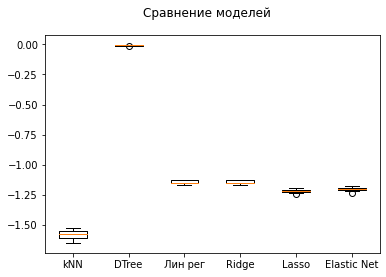

In [22]:
# построим ящик с усами
fig = pyplot.figure()
fig.suptitle('Сравнение моделей') # название
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

при использовании критерия качества "среднеквадратическая ошибка" смотрим по модулю. чем ближе к 0, тем лучше, следовательно, лучше всего себя показал DecisionTree

# Выбор лучшей модели классификации

In [23]:
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB # наивный байесовский классификатор
from sklearn.svm import SVC

In [25]:
filename = 'D:/Desktop/homework/daata for mash learning/creditcard.csv'
dataframe = pd.read_csv(filename)
dataframe.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [26]:
array = dataframe.values
X = array[:,0:30]
Y = array[:,30]

In [27]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [28]:
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

In [29]:
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7, shuffle=True)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.998971 (0.000228)
LDA: 0.999386 (0.000147)
KNN: 0.998385 (0.000250)
CART: 0.999185 (0.000181)
NB: 0.992858 (0.000583)
SVM: 0.998273 (0.000279)


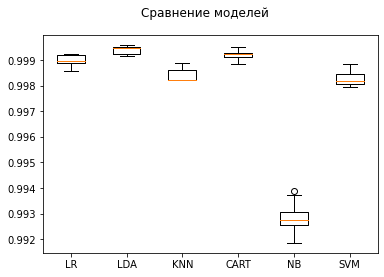

In [30]:
# построим ящик с усами
fig = pyplot.figure()
fig.suptitle('Сравнение моделей') # название
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

чем выше точность, тем лучше => лучшие модели CART и LDA (оранжевая полоска высокая)